## 人員と出荷数の相関を調べ予測する
目的 : 適切な人員配置を提案するため

In [49]:
# ライブラリのインポート
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [50]:
# 出荷データ.csvを読み込む
df = pd.read_csv("syukka.csv")
df.head(2)

,hizuke,youbi_syuku,tenki,jyugyoin_su,syukka_su,konpo_ari_wariai,toujitsu_syukka_wariai
0,2024-01-01,getu_syuku,kumori,11,3072,0.672,0.746
1,2024-01-02,ka,hare,38,2710,0.508,0.590


In [51]:
# dfの型を確認する
print(df[["hizuke", "youbi_syuku", "tenki"]].dtypes)
print(df.shape)

hizuke         object
youbi_syuku    object
tenki          object
dtype: object
(365, 7)


In [52]:
# 日付列をdatetime型に変換
df["hizuke"] = pd.to_datetime(df["hizuke"])
print(df["hizuke"].dtype)  # 変換後のデータ型を確認

datetime64[ns]


In [53]:
# 曜日(祝日)列にデータが何種類あるか調べる
df["youbi_syuku"].value_counts()

youbi_syuku
ka             52
moku           52
sui            51
kin            50
do             50
nichi          48
getu           46
getu_syuku      7
nichi_syuku     4
kin_syuku       2
do_syuku        2
sui_syuku       1
Name: count, dtype: int64

In [54]:
# 天気列にデータが何種類あるか調べる
df["tenki"].value_counts()

tenki
hare      237
kumori     99
ame        29
Name: count, dtype: int64

In [55]:
# 「曜日(祝日)」のダミー変数化と連結、削除
syukka_day = pd.get_dummies(df["youbi_syuku"], drop_first=True, dtype=int)
df2 = pd.concat([df, syukka_day], axis=1)
df2 = df2.drop(["youbi_syuku"], axis=1)

# 「天気」のダミー変数化と連結、削除 (既存の df2 に連結)
syukka_weather = pd.get_dummies(df["tenki"], drop_first=True, dtype=int)
df2 = pd.concat([df2, syukka_weather], axis=1)
df2 = df2.drop(["tenki"], axis=1)

df2.head(2)

,hizuke,jyugyoin_su,syukka_su,konpo_ari_wariai,toujitsu_syukka_wariai,do_syuku,getu,getu_syuku,ka,kin,kin_syuku,moku,nichi,nichi_syuku,sui,sui_syuku,hare,kumori
0,2024-01-01,11,3072,0.672,0.746,0,0,1,0,0,0,0,0,0,0,0,0,1
1,2024-01-02,38,2710,0.508,0.590,0,0,0,1,0,0,0,0,0,0,0,1,0


In [56]:
# 訓練&検証データとテストデータに分割
train_val, test = train_test_split(df2, test_size=0.2, random_state=0)

In [57]:
# 欠損値の確認 (今回は欠損値無し)
train_val.isnull().sum()

hizuke                    0
jyugyoin_su               0
syukka_su                 0
konpo_ari_wariai          0
toujitsu_syukka_wariai    0
do_syuku                  0
getu                      0
getu_syuku                0
ka                        0
kin                       0
kin_syuku                 0
moku                      0
nichi                     0
nichi_syuku               0
sui                       0
sui_syuku                 0
hare                      0
kumori                    0
dtype: int64

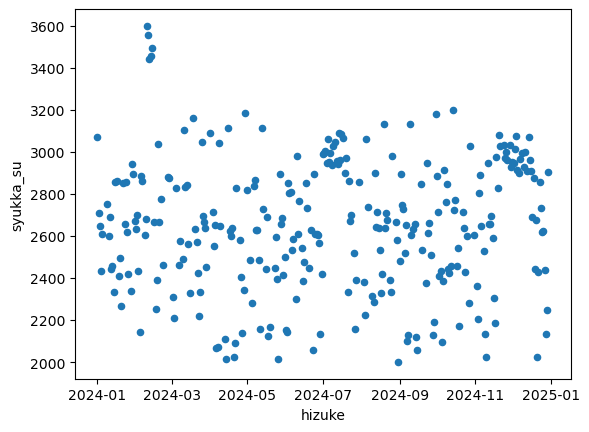

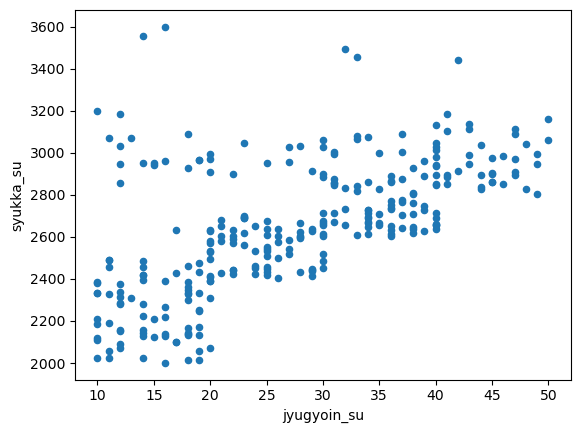

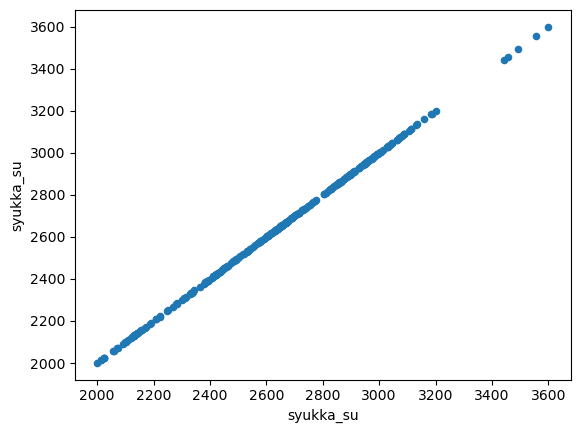

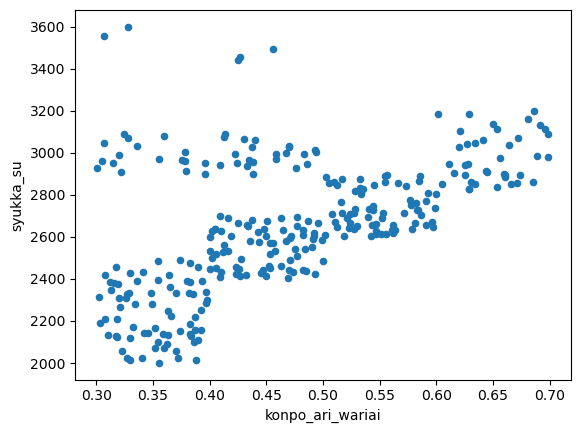

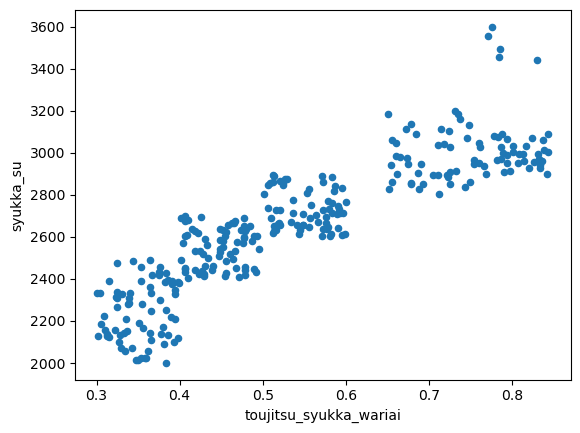

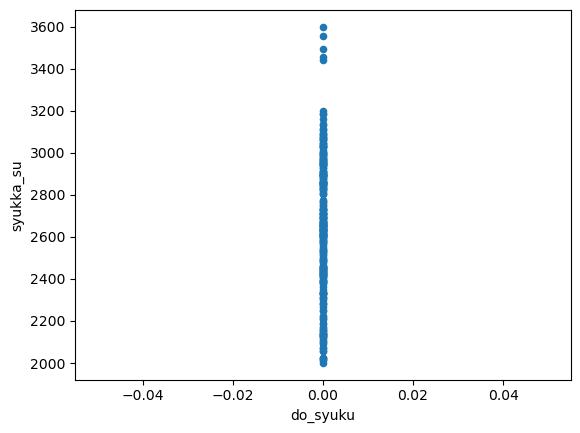

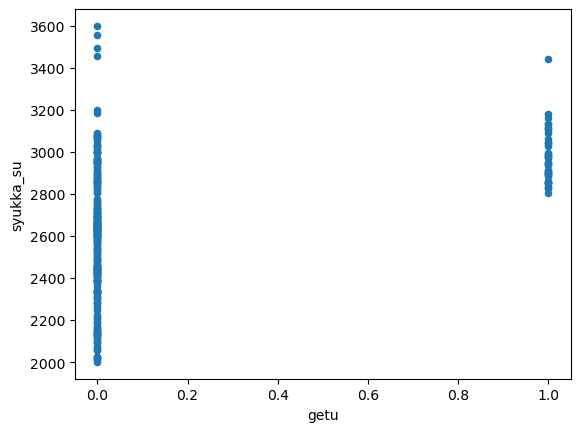

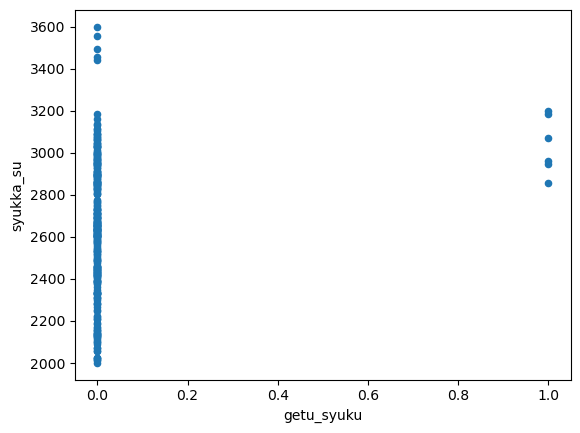

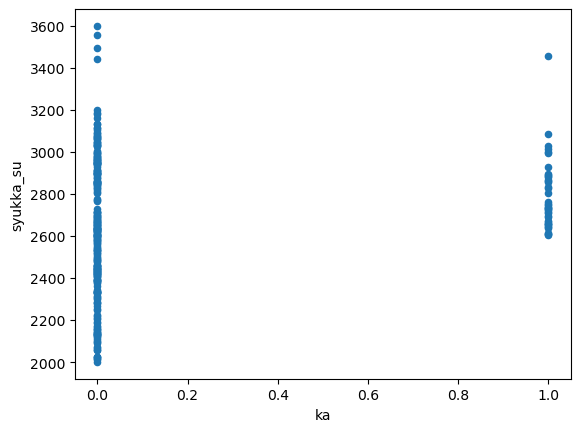

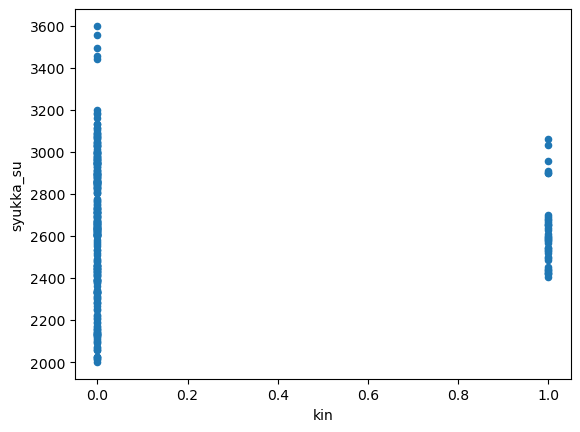

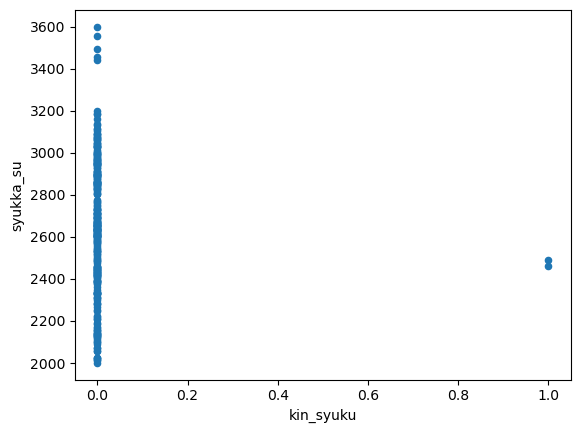

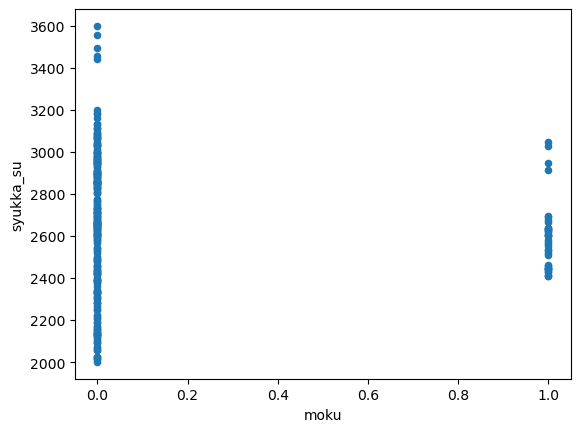

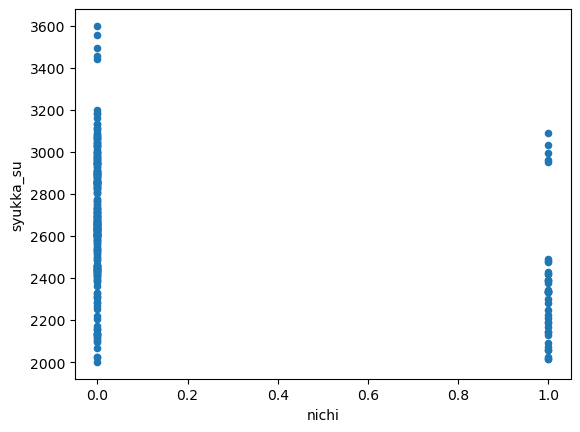

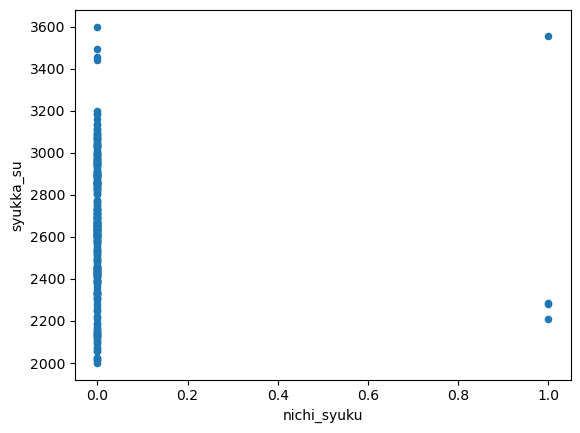

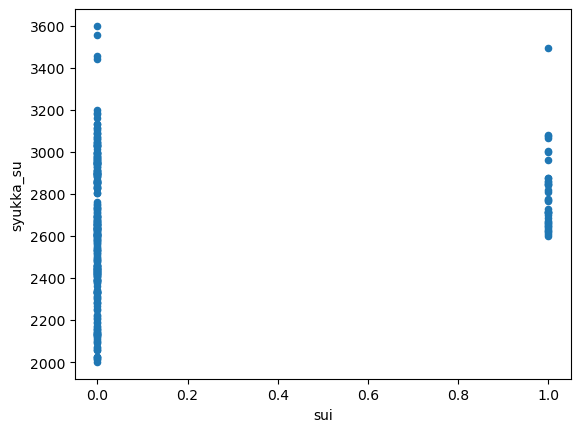

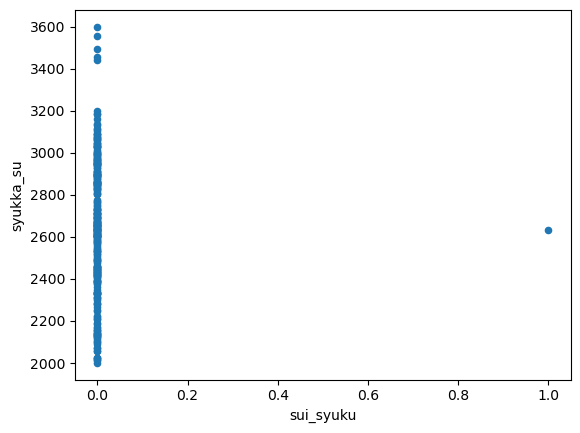

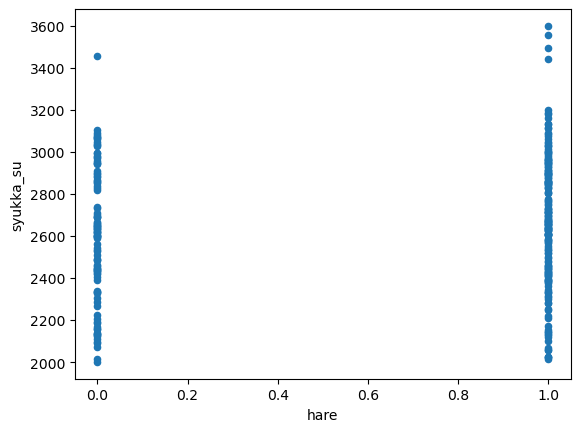

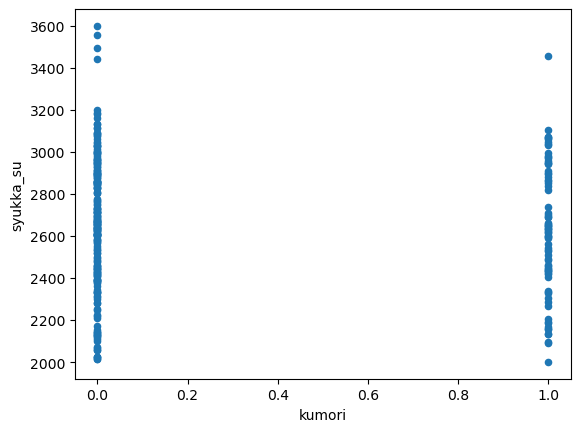

In [58]:
# 散布図で相関関係と外れ値の確認
colname = train_val.columns
for name in colname:
    train_val.plot(kind="scatter", x=name, y="syukka_su")

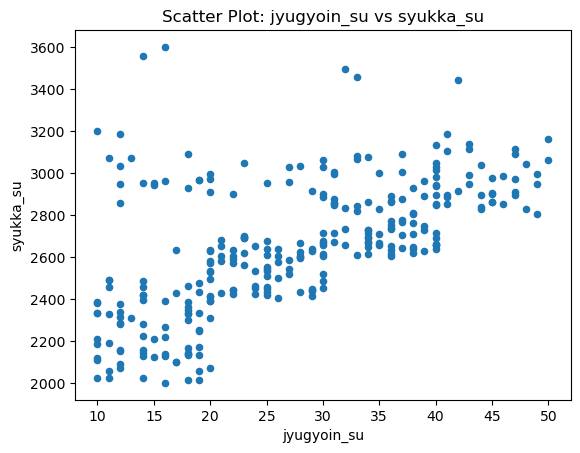

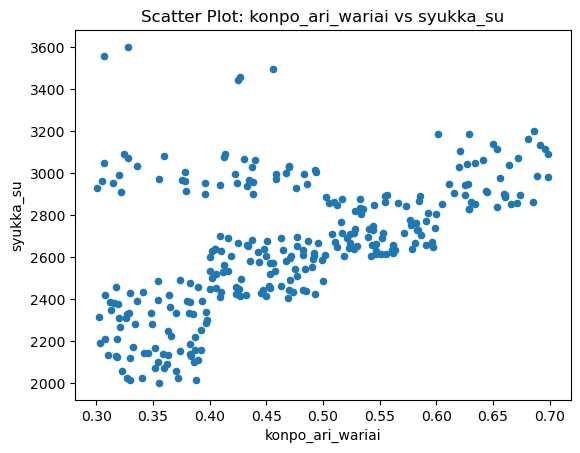

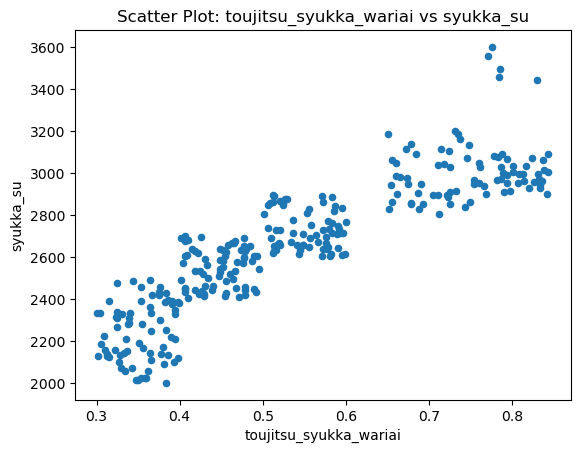

In [59]:
import matplotlib.pyplot as plt

features_to_plot = ["jyugyoin_su", "konpo_ari_wariai", "toujitsu_syukka_wariai"]
for feature in features_to_plot:
    train_val.plot(kind="scatter", x=feature, y="syukka_su")
    plt.title(f"Scatter Plot: {feature} vs syukka_su")
    plt.show()

In [60]:
# 外れ値のインデックスを確認
out_line = train_val[
    (train_val["konpo_ari_wariai"] < 0.35) & (train_val["syukka_su"] > 3580)
].index

print(out_line)

Index([40], dtype='int64')


In [61]:
# 外れ値を削除
train_val2 = train_val.drop([40], axis=0)

In [62]:
# 絞り込んだ列以外を取り除く
col = ["jyugyoin_su", "konpo_ari_wariai", "toujitsu_syukka_wariai", "syukka_su"]

train_val3 = train_val2[col]
train_val3.head(3)

,jyugyoin_su,konpo_ari_wariai,toujitsu_syukka_wariai,syukka_su
295,30,0.517,0.597,2716
63,44,0.629,0.652,2830
241,28,0.496,0.463,2668


In [63]:
# 列同士の相関関係を調べる
train_val3.corr()

,jyugyoin_su,konpo_ari_wariai,toujitsu_syukka_wariai,syukka_su
jyugyoin_su,1.000000,0.731590,0.571707,0.616102
konpo_ari_wariai,0.731590,1.000000,0.443889,0.553834
toujitsu_syukka_wariai,0.571707,0.443889,1.000000,0.884860
syukka_su,0.616102,0.553834,0.884860,1.000000


In [64]:
# 各列とsyukka_su列との相関関係を見る
train_col = train_val3.corr()["syukka_su"]
train_col

jyugyoin_su               0.616102
konpo_ari_wariai          0.553834
toujitsu_syukka_wariai    0.884860
syukka_su                 1.000000
Name: syukka_su, dtype: float64

In [65]:
# 絶対値に変換する
abs_cor = train_col.map(abs)
abs_cor

jyugyoin_su               0.616102
konpo_ari_wariai          0.553834
toujitsu_syukka_wariai    0.884860
syukka_su                 1.000000
Name: syukka_su, dtype: float64

In [66]:
# 降順に並び替え
abs_cor.sort_values(ascending=False)

syukka_su                 1.000000
toujitsu_syukka_wariai    0.884860
jyugyoin_su               0.616102
konpo_ari_wariai          0.553834
Name: syukka_su, dtype: float64

In [67]:
# 訓練データと検証データに分割
col = ["jyugyoin_su", "konpo_ari_wariai", "toujitsu_syukka_wariai"]
x = train_val3[col]
t = train_val3[["syukka_su"]]

x_train, x_val, y_train, y_val = train_test_split(x, t, test_size=0.2, random_state=0)

In [68]:
# 標準化
from sklearn.preprocessing import StandardScaler

sc_model_x = StandardScaler()
sc_model_x.fit(x_train)

# 各列のデータを標準化
sc_x = sc_model_x.transform(x_train)
sc_x

array([[ 6.35735823e-01,  6.96771164e-01,  2.53549082e-01],
       [-1.55708018e+00, -1.40630994e+00, -1.29692270e+00],
       [-3.17662438e-01,  2.32711014e-01, -6.72952352e-01],
       [-1.46174035e+00, -1.48529890e+00, -9.12456124e-01],
       [-3.16429595e-02, -3.20211717e-01,  1.58342529e+00],
       [ 1.59036693e-01, -6.85535665e-01, -8.17915161e-01],
       [-5.08342090e-01,  1.24101192e-01, -7.42282391e-01],
       [-8.89701394e-01, -1.15946944e+00, -1.13305170e+00],
       [-6.99021742e-01, -4.37503516e-02, -3.89329464e-01],
       [-1.65242000e+00, -7.84271867e-01, -1.07632713e+00],
       [-1.46174035e+00,  5.61774943e-03,  1.77250721e+00],
       [ 3.49716345e-01,  1.24969390e+00, -1.11656137e-02],
       [ 4.45056171e-01,  7.46139265e-01, -9.31011146e-02],
       [ 3.49716345e-01, -9.02755310e-01,  1.67166352e+00],
       [ 1.11243495e+00,  7.65886505e-01, -1.37220230e-01],
       [ 3.49716345e-01,  3.51194457e-01, -1.68733885e-01],
       [ 1.59036693e-01, -5.86799463e-01

In [69]:
# 平均値0を確認
tmp_df = pd.DataFrame(sc_x, columns=x_train.columns)
tmp_df.mean()  # 平均値の計算

jyugyoin_su              -8.422382e-17
konpo_ari_wariai         -6.699622e-16
toujitsu_syukka_wariai    1.339924e-17
dtype: float64

In [70]:
# 標準偏差1を確認
tmp_df.std()

jyugyoin_su               1.002162
konpo_ari_wariai          1.002162
toujitsu_syukka_wariai    1.002162
dtype: float64

In [71]:
# 正解データを標準化
sc_model_y = StandardScaler()
sc_model_y.fit(y_train)

sc_y = sc_model_y.transform(y_train)

In [72]:
# 標準化データで学習させる
model = LinearRegression()
model.fit(sc_x, sc_y)  # 標準化済みの訓練データで学習

LinearRegression()

In [73]:
# 検証データを標準化する
sc_x_val = sc_model_x.transform(x_val)
sc_y_val = sc_model_y.transform(y_val)
# 標準化した検証データで決定係数を計算
model.score(sc_x_val, sc_y_val)

0.8355369273267993

In [74]:
# learn関数の定義
# 検証しやすいようにlearn関数を定義する
def learn(x, t):
    x_train, x_val, y_train, y_val = train_test_split(
        x, t, test_size=0.2, random_state=0
    )

    # 訓練データを標準化
    sc_model_x = StandardScaler()
    sc_model_y = StandardScaler()
    sc_model_x.fit(x_train)
    sc_x_train = sc_model_x.transform(x_train)
    sc_model_y.fit(y_train)
    sc_y_train = sc_model_y.transform(y_train)
    # 学習
    model = LinearRegression()
    model.fit(sc_x_train, sc_y_train)

    # 検証データを標準化
    sc_x_val = sc_model_x.transform(x_val)
    sc_y_val = sc_model_y.transform(y_val)
    # 訓練データと検証データの決定係数計算
    train_score = model.score(sc_x_train, sc_y_train)
    val_score = model.score(sc_x_val, sc_y_val)

    return train_score, val_score

In [75]:
# learn関数を実行
x = train_val3.loc[:, ["jyugyoin_su", "konpo_ari_wariai", "toujitsu_syukka_wariai"]]
t = train_val3[["syukka_su"]]

s1, s2 = learn(x, t)
print(s1, s2)

0.8099898362844229 0.8355369273267993


In [76]:
# 特徴量エンジニアリング(列のデータを2乗する)
x["toujitsu_syukka_wariai"] ** 2

295    0.356409
63     0.425104
241    0.214369
306    0.132496
317    0.301401
         ...   
323    0.309136
192    0.579121
117    0.097969
47     0.146689
172    0.229441
Name: toujitsu_syukka_wariai, Length: 291, dtype: float64

In [77]:
# 2乗したシリーズを新しい列として追加
x["toujitsu_syukka_wariai2"] = x["toujitsu_syukka_wariai"] ** 2
x.head(2)

,jyugyoin_su,konpo_ari_wariai,toujitsu_syukka_wariai,toujitsu_syukka_wariai2
295,30,0.517,0.597,0.356409
63,44,0.629,0.652,0.425104


In [78]:
# 新しい列を追加したので再学習
s1, s2 = learn(x, t)
print(s1, s2)

0.8155016959747383 0.8421333432788354


In [79]:
# 他の残り2列も新しい列を追加する
x["jyugyoin_su2"] = x["jyugyoin_su"] ** 2
s1, s2 = learn(x, t)
print(s1, s2)

x["konpo_ari_wariai2"] = x["konpo_ari_wariai"] ** 2
s1, s2 = learn(x, t)
print(s1, s2)

0.8185482478887657 0.8417493368302456
0.8185523272821033 0.8417826572276332


In [80]:
# 訓練データと検証データを合わせて再学習させるので再度標準化
sc_model_x2 = StandardScaler()
sc_model_x2.fit(x)
sc_x = sc_model_x2.transform(x)

sc_model_y2 = StandardScaler()
sc_model_y2.fit(t)
sc_y = sc_model_y2.transform(t)
model = LinearRegression()
model.fit(sc_x, sc_y)

LinearRegression()

In [81]:
# テストデータの前処理
test2 = test.fillna(train_val.mean())
x_test = test2.loc[:, ["jyugyoin_su", "konpo_ari_wariai", "toujitsu_syukka_wariai"]]
y_test = test2[["syukka_su"]]

x_test["toujitsu_syukka_wariai2"] = x_test["toujitsu_syukka_wariai"] ** 2
x_test["jyugyoin_su2"] = x_test["jyugyoin_su"] ** 2
x_test["konpo_ari_wariai2"] = x_test["konpo_ari_wariai"] ** 2

sc_x_test = sc_model_x2.transform(x_test)
sc_y_test = sc_model_y2.transform(y_test)

In [82]:
# 決定係数を計算する
model.score(sc_x_test, sc_y_test)

0.8004962736968755

## テストデータでの目標値0.8を達成

In [83]:
# モデルを保存
import pickle

with open("syukka.pkl", "wb") as f:
    pickle.dump(model, f)
with open("syukka_scx.pkl", "wb") as f:
    pickle.dump(sc_model_x2, f)
with open("syukka_scy.pkl", "wb") as f:
    pickle.dump(sc_model_y2, f)

## 具体的な数値を入れて予測

In [84]:
import pickle
import pandas as pd
import numpy as np

# 保存したモデルとスケーラーをロード
with open("syukka.pkl", "rb") as f:
    loaded_model = pickle.load(f)
with open("syukka_scx.pkl", "rb") as f:
    loaded_scaler_x = pickle.load(f)
with open("syukka_scy.pkl", "rb") as f:
    loaded_scaler_y = pickle.load(f)

# 予測したい従業員数
predict_employees = [30, 40]

# 過去のデータから梱包あり割合と当日出荷割合の平均値を計算
# 'train_val' は学習に使用したデータフレームと仮定
mean_konpo = train_val["konpo_ari_wariai"].mean()
mean_toujitsu = train_val["toujitsu_syukka_wariai"].mean()

# 予測用の新しいデータ (DataFrame形式)
new_data = pd.DataFrame({
    "jyugyoin_su": predict_employees,
    "konpo_ari_wariai": [mean_konpo] * len(predict_employees),
    "toujitsu_syukka_wariai": [mean_toujitsu] * len(predict_employees)
})

# 学習時と同じ特徴量エンジニアリングを適用 (二乗項の作成)
new_data["toujitsu_syukka_wariai2"] = new_data["toujitsu_syukka_wariai"] ** 2
new_data["jyugyoin_su2"] = new_data["jyugyoin_su"] ** 2
new_data["konpo_ari_wariai2"] = new_data["konpo_ari_wariai"] ** 2

# 特徴量の順序を学習時と同じにする (重要！)
feature_order = ["jyugyoin_su", "konpo_ari_wariai", "toujitsu_syukka_wariai", "toujitsu_syukka_wariai2", "jyugyoin_su2", "konpo_ari_wariai2"]
new_data_ordered = new_data[feature_order]

# 新しいデータを学習時に使用したスケーラーで標準化
scaled_new_data = loaded_scaler_x.transform(new_data_ordered)

# 標準化されたデータで予測
scaled_predictions = loaded_model.predict(scaled_new_data)

# 予測結果を元のスケールに戻す
predictions_original_scale = loaded_scaler_y.inverse_transform(scaled_predictions.reshape(-1, 1))

# 結果の表示
for employees, prediction in zip(predict_employees, predictions_original_scale):
    print(f"従業員数 {employees} 人の場合の予測出荷数: {prediction[0]:.2f}")

従業員数 30 人の場合の予測出荷数: 2689.71
従業員数 40 人の場合の予測出荷数: 2668.88


In [85]:
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# 保存したモデルとスケーラーをロード
with open("syukka.pkl", "rb") as f:
    loaded_model = pickle.load(f)
with open("syukka_scx.pkl", "rb") as f:
    loaded_scaler_x = pickle.load(f)
with open("syukka_scy.pkl", "rb") as f:
    loaded_scaler_y = pickle.load(f)

# 予測したい新しいデータ (DataFrame形式)
new_data = pd.DataFrame({
    "jyugyoin_su": [30, 40],
    "konpo_ari_wariai": [0.6, 0.55],
    "toujitsu_syukka_wariai": [0.7, 0.65]
})

# 学習時と同じ特徴量エンジニアリングを適用 (二乗項の作成)
new_data["toujitsu_syukka_wariai2"] = new_data["toujitsu_syukka_wariai"] ** 2
new_data["jyugyoin_su2"] = new_data["jyugyoin_su"] ** 2
new_data["konpo_ari_wariai2"] = new_data["konpo_ari_wariai"] ** 2

# 特徴量の順序を学習時と同じにする (重要！)
feature_order = ["jyugyoin_su", "konpo_ari_wariai", "toujitsu_syukka_wariai", "toujitsu_syukka_wariai2", "jyugyoin_su2", "konpo_ari_wariai2"]
new_data_ordered = new_data[feature_order]

# 新しいデータを学習時に使用したスケーラーで標準化
scaled_new_data = loaded_scaler_x.transform(new_data_ordered)

# 標準化されたデータで予測
scaled_predictions = loaded_model.predict(scaled_new_data)

# 予測結果を元のスケールに戻す
# predict の出力は (n_samples,) の1次元配列なので、reshape(-1, 1) で2次元配列に変換
predictions_original_scale = loaded_scaler_y.inverse_transform(scaled_predictions.reshape(-1, 1))

# 結果の表示
print("標準化された予測結果:")
print(scaled_predictions)
print("\n元のスケールに戻した予測結果 (出荷数):")
print(predictions_original_scale)

標準化された予測結果:
[[1.13056139]
 [0.76242018]]

元のスケールに戻した予測結果 (出荷数):
[[2995.45252723]
 [2881.85161028]]


## 予測してみた結果
・従業員数が増えると出荷数が下がるという相反する予測がでる \
・出荷数に最も影響を与えているのは当日出荷数である \
・モデルとして使えないため、別のモデル「ランダムフォレスト」を試みる

## ランダムフォレスト(回帰)

・従業員数のみ入力して予測するモデル

In [86]:
# ライブラリのインポート
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor  # ランダムフォレストのインポート
import pickle
import numpy as np

# 出荷データ.csvを読み込む
df = pd.read_csv("syukka.csv")

# 日付列をdatetime型に変換
df["hizuke"] = pd.to_datetime(df["hizuke"])

# 「曜日(祝日)」のダミー変数化と連結、削除
syukka_day = pd.get_dummies(df["youbi_syuku"], drop_first=True, dtype=int)
df2 = pd.concat([df, syukka_day], axis=1)
df2 = df2.drop(["youbi_syuku"], axis=1)

# 「天気」のダミー変数化と連結、削除 (既存の df2 に連結)
syukka_weather = pd.get_dummies(df["tenki"], drop_first=True, dtype=int)
df2 = pd.concat([df2, syukka_weather], axis=1)
df2 = df2.drop(["tenki"], axis=1)

# 訓練&検証データとテストデータに分割
train_val, test = train_test_split(df2, test_size=0.2, random_state=0)

# 外れ値を削除 (以前特定した外れ値が存在する場合)
if 40 in train_val.index:
    train_val2 = train_val.drop([40], axis=0)
else:
    train_val2 = train_val.copy()

# 絞り込んだ列
col = ["jyugyoin_su", "konpo_ari_wariai", "toujitsu_syukka_wariai", "syukka_su"]
train_val3 = train_val2[col].copy()  # .copy() を追加して警告を回避

# 特徴量とターゲット変数を準備
col_features = ["jyugyoin_su", "konpo_ari_wariai", "toujitsu_syukka_wariai"]
x = train_val3[col_features].copy()  # .copy() を追加して警告を回避
t = train_val3[["syukka_su"]].copy()  # .copy() を追加して警告を回避

# 特徴量エンジニアリング (二乗項の追加)
x["toujitsu_syukka_wariai2"] = x["toujitsu_syukka_wariai"] ** 2
x["jyugyoin_su2"] = x["jyugyoin_su"] ** 2
x["konpo_ari_wariai2"] = x["konpo_ari_wariai"] ** 2

# 訓練データと検証データに分割
x_train, x_val, y_train, y_val = train_test_split(x, t, test_size=0.2, random_state=0)

# 標準化 (特徴量のみ)
sc_model_x = StandardScaler()
sc_model_x.fit(x_train)
sc_x_train = sc_model_x.transform(x_train)
sc_x_val = sc_model_x.transform(x_val)
sc_x = sc_model_x.transform(x)  # 全訓練データ用

# ランダムフォレストモデルで学習
rf_model = RandomForestRegressor(random_state=0)
rf_model.fit(sc_x_train, y_train.values.ravel())  # y_trainを1次元配列に変換

# テストデータの前処理
test2 = test.fillna(train_val.mean()).copy()  # .copy() を追加して警告を回避
x_test = test2[col_features].copy()  # .copy() を追加して警告を回避
y_test = test2[["syukka_su"]].copy()  # .copy() を追加して警告を回避

# テストデータにも特徴量エンジニアリングを適用
x_test["toujitsu_syukka_wariai2"] = x_test["toujitsu_syukka_wariai"] ** 2
x_test["jyugyoin_su2"] = x_test["jyugyoin_su"] ** 2
x_test["konpo_ari_wariai2"] = x_test["konpo_ari_wariai"] ** 2

# テストデータを標準化
sc_x_test = sc_model_x.transform(x_test)

# モデルを保存 (ランダムフォレストモデル)
with open("syukka_rf.pkl", "wb") as f:
    pickle.dump(rf_model, f)
with open("syukka_scx_rf.pkl", "wb") as f:
    pickle.dump(sc_model_x, f)
# sc_y はターゲット変数のスケーラーなので、ランダムフォレストでは通常保存しません

# 保存したランダムフォレストモデルで予測
with open("syukka_rf.pkl", "rb") as f:
    loaded_rf_model = pickle.load(f)
with open("syukka_scx_rf.pkl", "rb") as f:
    loaded_scaler_x_rf = pickle.load(f)

# 予測したい従業員数
predict_employees = [35, 40]

# 過去のデータから梱包あり割合と当日出荷割合の平均値を計算
mean_konpo = train_val["konpo_ari_wariai"].mean()
mean_toujitsu = train_val["toujitsu_syukka_wariai"].mean()

# 予測用の新しいデータ (DataFrame形式)
new_data = pd.DataFrame(
    {
        "jyugyoin_su": predict_employees,
        "konpo_ari_wariai": [mean_konpo] * len(predict_employees),
        "toujitsu_syukka_wariai": [mean_toujitsu] * len(predict_employees),
    }
)

# 学習時と同じ特徴量エンジニアリングを適用 (二乗項の作成)
new_data["toujitsu_syukka_wariai2"] = new_data["toujitsu_syukka_wariai"] ** 2
new_data["jyugyoin_su2"] = new_data["jyugyoin_su"] ** 2
new_data["konpo_ari_wariai2"] = new_data["konpo_ari_wariai"] ** 2

# 特徴量の順序を学習時と同じにする (重要！)
feature_order_rf = [
    "jyugyoin_su",
    "konpo_ari_wariai",
    "toujitsu_syukka_wariai",
    "toujitsu_syukka_wariai2",
    "jyugyoin_su2",
    "konpo_ari_wariai2",
]
new_data_ordered_rf = new_data[feature_order_rf]

# 新しいデータを学習時に使用したスケーラーで標準化
scaled_new_data_rf = loaded_scaler_x_rf.transform(new_data_ordered_rf)

# 標準化されたデータで予測
predictions_scaled_rf = loaded_rf_model.predict(scaled_new_data_rf)

# ランダムフォレストモデルではターゲット変数を標準化していないため、
# 逆変換は不要です。

# 結果の表示
print("\nランダムフォレストモデルでの予測結果 (出荷数):")
for employees, prediction in zip(predict_employees, predictions_scaled_rf):
    print(f"従業員数 {employees} 人の場合の予測出荷数: {prediction:.2f}")


ランダムフォレストモデルでの予測結果 (出荷数):
従業員数 35 人の場合の予測出荷数: 2737.04
従業員数 40 人の場合の予測出荷数: 2745.11


・従業員数ほか2つの要素を元に予測するモデル

In [87]:
import pickle
import pandas as pd
import numpy as np

# 保存したランダムフォレストモデルとスケーラーをロード
with open("syukka_rf.pkl", "rb") as f:
    loaded_rf_model = pickle.load(f)
with open("syukka_scx_rf.pkl", "rb") as f:
    loaded_scaler_x_rf = pickle.load(f)

# 予測したい新しいデータ (DataFrame形式)
new_data = pd.DataFrame(
    {
        "jyugyoin_su": [35, 40],
        "konpo_ari_wariai": [0.3, 0.5],
        "toujitsu_syukka_wariai": [0.5, 0.3],
    }
)

# 学習時と同じ特徴量エンジニアリングを適用 (二乗項の作成)
new_data["toujitsu_syukka_wariai2"] = new_data["toujitsu_syukka_wariai"] ** 2
new_data["jyugyoin_su2"] = new_data["jyugyoin_su"] ** 2
new_data["konpo_ari_wariai2"] = new_data["konpo_ari_wariai"] ** 2

# 特徴量の順序を学習時と同じにする (重要！)
feature_order_rf = [
    "jyugyoin_su",
    "konpo_ari_wariai",
    "toujitsu_syukka_wariai",
    "toujitsu_syukka_wariai2",
    "jyugyoin_su2",
    "konpo_ari_wariai2",
]
new_data_ordered_rf = new_data[feature_order_rf]

# 新しいデータを学習時に使用したスケーラーで標準化
scaled_new_data_rf = loaded_scaler_x_rf.transform(new_data_ordered_rf)

# 標準化されたデータで予測
predictions_scaled_rf = loaded_rf_model.predict(scaled_new_data_rf)

# 結果の表示
print("\nランダムフォレストモデルでの予測結果 (出荷数):")
for i in range(len(new_data)):
    employees = new_data["jyugyoin_su"][i]
    konpo_ari = new_data["konpo_ari_wariai"][i]
    toujitsu_syukka = new_data["toujitsu_syukka_wariai"][i]
    prediction = predictions_scaled_rf[i]
    print(
        f"従業員数 {employees} 人, 梱包率 {konpo_ari:.2f}, 当日出荷率 {toujitsu_syukka:.2f} の場合の予測出荷数: {prediction:.2f}"
    )


ランダムフォレストモデルでの予測結果 (出荷数):
従業員数 35 人, 梱包率 0.30, 当日出荷率 0.50 の場合の予測出荷数: 2693.96
従業員数 40 人, 梱包率 0.50, 当日出荷率 0.30 の場合の予測出荷数: 2458.57


曜日ごとの出荷数ヒストグラムの作成

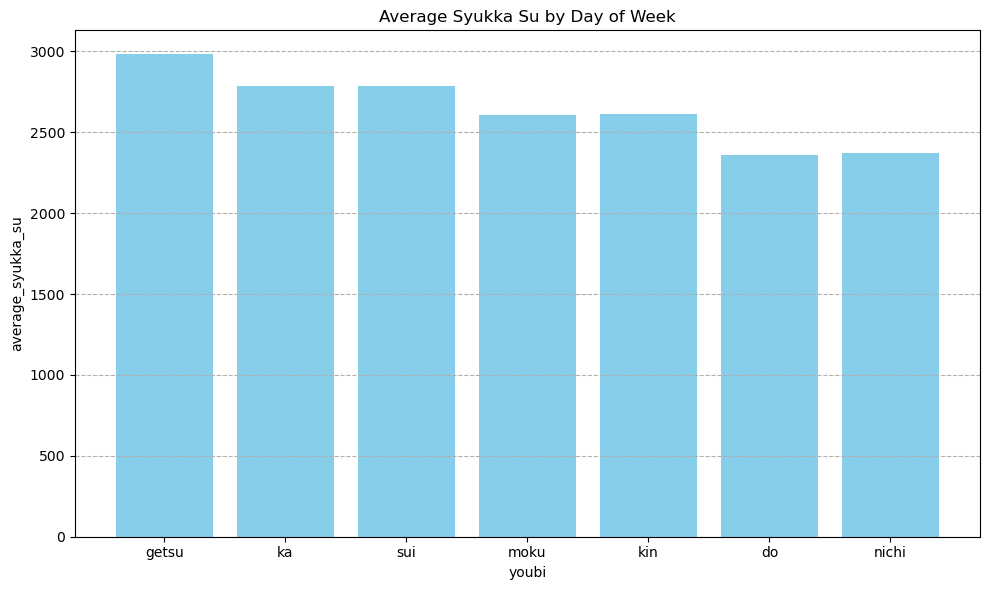

In [88]:
import pandas as pd
import matplotlib.pyplot as plt

# CSVファイルの読み込み
file_path = "syukka.csv"
df = pd.read_csv(file_path)

# 'hizuke' を datetime 型に変換
df['hizuke'] = pd.to_datetime(df['hizuke'])

# 曜日番号 → ローマ字のマッピング
youbi_romaji = {0: 'getsu', 1: 'ka', 2: 'sui', 3: 'moku', 4: 'kin', 5: 'do', 6: 'nichi'}
df['youbi'] = df['hizuke'].dt.dayofweek.map(youbi_romaji)

# 曜日ごとの出荷数平均を集計
weekly_shipments = df.groupby('youbi')['syukka_su'].mean()

# 曜日を並び替え
weekday_order = ['getsu', 'ka', 'sui', 'moku', 'kin', 'do', 'nichi']
weekly_shipments = weekly_shipments.reindex(weekday_order)

# ヒストグラム作成
plt.figure(figsize=(10, 6))
plt.bar(weekly_shipments.index, weekly_shipments.values, color='skyblue')
plt.xlabel("youbi")
plt.ylabel("average_syukka_su")
plt.title("Average Syukka Su by Day of Week")
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

syukka_su                 1.000000 \
toujitsu_syukka_wariai    0.884860 \
jyugyoin_su               0.616102 \
konpo_ari_wariai          0.553834 \
Name: syukka_su, dtype: float64

## モデル作成・分析してわかったこと

※ あくまでもダミー数値であることは考慮したうえで… \
 \
・出荷数と影響度が強いのは、意外にも「当日出荷の割合」だった \
・従業員の数が増えても、出荷数が増えるわけではない \
・出荷数に影響を与えている要素が他にもある可能性